In [1]:
%%capture
!pip install pedalboard
!pip install -q keras-tcn --no-dependencies

In [2]:
%%capture
# download the audio files
!wget https://github.com/nicolagulmini/plugins/raw/main/Python/wav/clean.wav
!wget https://github.com/nicolagulmini/plugins/raw/main/Python/wav/effect.wav
!wget https://github.com/nicolagulmini/plugins/raw/main/Python/wav/loop.wav

In [3]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from tcn import TCN, tcn_full_summary
from pedalboard.io import AudioFile
from pedalboard import Pedalboard, Reverb
import math

In [4]:
sr = 44100

In [5]:
with AudioFile("clean.wav").resampled_to(sr) as i: cleanAudio_mono = i.read(i.frames)
with AudioFile("effect.wav").resampled_to(sr) as i: fxAudio = i.read(i.frames)

cleanAudio = np.array([cleanAudio_mono[0], cleanAudio_mono[0]])
print(cleanAudio.shape)
print(fxAudio.shape)

X_train = cleanAudio[:, :705000]
X_train = X_train.transpose((1, 0))
X_train = X_train.reshape((-1, 1000, 2))

Y_train = fxAudio[:, :705000]
Y_train = Y_train.transpose((1, 0))
Y_train = Y_train.reshape((-1, 1000, 2))

print(X_train.shape)
print(Y_train.shape)

# fxAudio is too difficult, let's try with a simple reverb
'''
board = Pedalboard([Reverb(room_size=0.25)])
fxAudio = board(cleanAudio, sr)
Y_train = processY(fxAudio, N)
'''

(2, 705600)
(2, 705600)
(705, 1000, 2)
(705, 1000, 2)


'\nboard = Pedalboard([Reverb(room_size=0.25)])\nfxAudio = board(cleanAudio, sr)\nY_train = processY(fxAudio, N)\n'

In [6]:
# https://github.com/TensorSpeech/TensorflowTTS/blob/master/tensorflow_tts/losses/stft.py

#@title Code for custom loss function

class TFSpectralConvergence(tf.keras.layers.Layer):
    """Spectral convergence loss."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.norm(y_mag - x_mag, ord="fro", axis=(-2, -1)) / tf.norm(
            y_mag, ord="fro", axis=(-2, -1)
        )

class TFLogSTFTMagnitude(tf.keras.layers.Layer):
    """Log STFT magnitude loss module."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.abs(tf.math.log(y_mag+1e-5) - tf.math.log(x_mag+1e-5))

class TFSTFT(tf.keras.layers.Layer):
    """STFT loss module."""

    def __init__(self, frame_length=600, frame_step=120, fft_length=1024):
        """Initialize."""
        super().__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length
        self.spectral_convergenge_loss = TFSpectralConvergence()
        self.log_stft_magnitude_loss = TFLogSTFTMagnitude()

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Spectral convergence loss value (pre-reduce).
            Tensor: Log STFT magnitude loss value (pre-reduce).
        """
        x_mag = tf.abs(
            tf.signal.stft(
                signals=tf.transpose(x, perm=[0, 2, 1]),
                frame_length=self.frame_length,
                frame_step=self.frame_step,
                fft_length=self.fft_length,
            )
        )
        y_mag = tf.abs(
            tf.signal.stft(
                signals=tf.transpose(y, perm=[0, 2, 1]),
                frame_length=self.frame_length,
                frame_step=self.frame_step,
                fft_length=self.fft_length,
            )
        )
        # add small number to prevent nan value.
        # compatible with pytorch version.
        x_mag = tf.clip_by_value(tf.math.sqrt(x_mag ** 2 + 1e-7), 1e-7, 1e3)
        y_mag = tf.clip_by_value(tf.math.sqrt(y_mag ** 2 + 1e-7), 1e-7, 1e3)

        sc_loss = self.spectral_convergenge_loss(y_mag, x_mag)
        mag_loss = self.log_stft_magnitude_loss(y_mag, x_mag)

        return sc_loss, mag_loss

class TFMultiResolutionSTFT(tf.keras.layers.Layer):
    """Multi resolution STFT loss module."""

    def __init__(
        self,
        fft_lengths=[512, 256, 128], #fft_lengths=[1024, 2048, 512],
        frame_lengths=[512, 256, 128], #frame_lengths=[600, 1200, 240],
        frame_steps=[120, 240, 50], #frame_steps=[120, 240, 50],
    ):
        """Initialize Multi resolution STFT loss module.
        Args:
            frame_lengths (list): List of FFT sizes.
            frame_steps (list): List of hop sizes.
            fft_lengths (list): List of window lengths.
        """
        super().__init__()
        assert len(frame_lengths) == len(frame_steps) == len(fft_lengths)
        self.stft_losses = []
        for frame_length, frame_step, fft_length in zip(
            frame_lengths, frame_steps, fft_lengths
        ):
            self.stft_losses.append(TFSTFT(frame_length, frame_step, fft_length))

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Multi resolution spectral convergence loss value.
            Tensor: Multi resolution log STFT magnitude loss value.
        """
        sc_loss = 0.0
        mag_loss = 0.0
        for f in self.stft_losses:
            sc_l, mag_l = f(y, x)
            sc_loss += tf.reduce_mean(sc_l, axis=list(range(1, len(sc_l.shape))))
            mag_loss += tf.reduce_mean(mag_l, axis=list(range(1, len(mag_l.shape))))

        sc_loss /= len(self.stft_losses)
        mag_loss /= len(self.stft_losses)
        return sc_loss, mag_loss

In [21]:
#@title Model
class nnModel:

    def __init__(self):

        input = tf.keras.Input(shape=(1000, 2))

        x = TCN(nb_filters=16,
                kernel_size=8,
                nb_stacks=16,
                dilations=(1, 2, 4, 8, 16),
                padding='causal',
                use_skip_connections=True,
                dropout_rate=0.1,
                return_sequences=True,
                activation='relu',
                kernel_initializer='he_normal',
                use_batch_norm=True
            )(input)

        x = TCN(nb_filters=2,
                kernel_size=8,
                nb_stacks=4,
                padding='causal',
                use_skip_connections=True,
                dropout_rate=0.1,
                return_sequences=True,
                activation='relu',
                kernel_initializer='he_normal',
                use_batch_norm=True
            )(x)

        def custom_loss(y_true, y_pred):
            mr_stft = TFMultiResolutionSTFT()
            loss = tf.keras.losses.MeanSquaredError()
            t = loss(y_true, y_pred)
            sc_loss, mag_loss = mr_stft(y_true, y_pred)
            return sc_loss + mag_loss + t

        model = tf.keras.models.Model(inputs=input, outputs=x)
        model.compile(optimizer='adam', loss=custom_loss,
                      metrics=['mse', 'mae'],
                      run_eagerly=True)

        self.model = model

    def getInfo(self):
        self.model.summary()

    def trainNetwork(self, x, y, batchSize, epochs, verbose=2):
        return self.model.fit(x=x, y=y, batch_size=batchSize, epochs=epochs, verbose=verbose)

    def predict(self, batchAudioStereo):
        res = self.model.predict(batchAudioStereo)
        outputL = []
        outputR = []
        res = res.transpose((0, 2, 1))
        for i in range(res.shape[0]):
            for sample in res[i, 0]:
                outputL.append(sample)
            for sample in res[i, 1]:
                outputR.append(sample)
        return np.array([np.array(outputL), np.array(outputR)])

In [22]:
neuralNetwork = nnModel()
neuralNetwork.getInfo()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000, 2)]         0         
                                                                 
 tcn_4 (TCN)                 (None, 1000, 16)          338736    
                                                                 
 tcn_5 (TCN)                 (None, 1000, 2)           2274      
                                                                 
Total params: 341010 (1.30 MB)
Trainable params: 335698 (1.28 MB)
Non-trainable params: 5312 (20.75 KB)
_________________________________________________________________


In [23]:
EPOCHS = 20
history = neuralNetwork.trainNetwork(X_train, Y_train, 32, EPOCHS)

Epoch 1/20
23/23 - 296s - loss: 239.6030 - mse: 52.6854 - mae: 4.3122 - 296s/epoch - 13s/step
Epoch 2/20
23/23 - 294s - loss: 107.3963 - mse: 38.8601 - mae: 1.7362 - 294s/epoch - 13s/step
Epoch 3/20
23/23 - 304s - loss: 55.8510 - mse: 30.8019 - mae: 1.2399 - 304s/epoch - 13s/step
Epoch 4/20
23/23 - 300s - loss: 21.0029 - mse: 5.1495 - mae: 0.4101 - 300s/epoch - 13s/step
Epoch 5/20
23/23 - 304s - loss: 14.0218 - mse: 1.9118 - mae: 0.2434 - 304s/epoch - 13s/step
Epoch 6/20
23/23 - 301s - loss: 11.6720 - mse: 0.4611 - mae: 0.1669 - 301s/epoch - 13s/step
Epoch 7/20
23/23 - 293s - loss: 12.9020 - mse: 2.0822 - mae: 0.2066 - 293s/epoch - 13s/step
Epoch 8/20
23/23 - 296s - loss: 8.3628 - mse: 0.4543 - mae: 0.1629 - 296s/epoch - 13s/step
Epoch 9/20
23/23 - 300s - loss: 7.2237 - mse: 0.4277 - mae: 0.1579 - 300s/epoch - 13s/step
Epoch 10/20
23/23 - 296s - loss: 7.2088 - mse: 0.4171 - mae: 0.1600 - 296s/epoch - 13s/step
Epoch 11/20
23/23 - 297s - loss: 7.5898 - mse: 0.4259 - mae: 0.1489 - 297s/ep

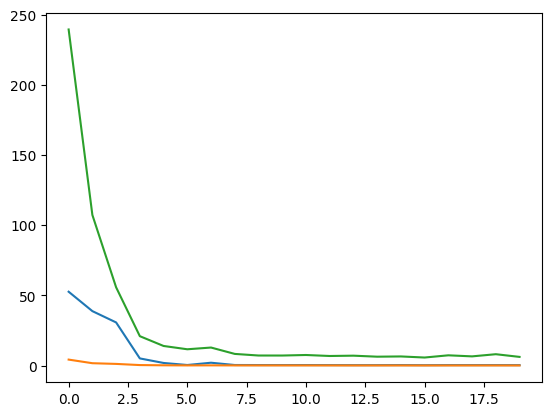

In [24]:
plt.plot(range(EPOCHS), history.history['mse'])
plt.plot(range(EPOCHS), history.history['mae'])
plt.plot(range(EPOCHS), history.history['loss'])
plt.show()

In [25]:
with AudioFile("loop.wav").resampled_to(sr) as i: loop_mono = i.read(i.frames)
loop = np.array([loop_mono[0], loop_mono[0]])

new_loop = loop[:,:360000]
new_loop = new_loop.transpose((1, 0))
new_loop = new_loop.reshape((-1, 1000, 2))

output = neuralNetwork.predict(new_loop)

with AudioFile('processed-output.wav', 'w', sr, output.shape[0]) as f: f.write(output)

12/12 [==============================] - 38s 3s/step
